In [1]:
#Using APRBS with a 180 degree peak to peak

In [2]:
from keras import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
import pandas as pd
import numpy as np
import math
from simulation_tools import PRBS
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [4]:
df = pd.read_csv('aprbs_180ptp_log.txt')
df = df.drop(['timestamp'], axis=1)
#Centre positions at 0
df[['rot_command', 'flex_command', 'rot_cur_pos', 
    'flex_cur_pos','rot_next_pos', 'flex_next_pos']] = df[['rot_command', 'flex_command', 
                                                           'rot_cur_pos', 'flex_cur_pos', 
                                                           'rot_next_pos', 'flex_next_pos']] - 2048

#Centre velocities at 0
df[['rot_cur_vel', 'flex_cur_vel', 
    'rot_next_vel', 'flex_next_vel']] = df[['rot_cur_vel', 'flex_cur_vel', 'rot_next_vel', 'flex_next_vel']] - 1024
#Convert to radians
df = df * 2 * math.pi/4096
df.head()

,rot_command,flex_command,rot_cur_pos,flex_cur_pos,rot_next_pos,flex_next_pos,rot_cur_vel,flex_cur_vel,rot_next_vel,flex_next_vel
0,-3.141593,-3.141593,0.001534,-0.012272,0.001534,-0.012272,-1.570796,-1.570796,-1.570796,-1.570796
1,0.490874,0.490874,0.001534,-0.012272,0.001534,-0.012272,-1.570796,-1.570796,-1.570796,-1.570796
2,0.490874,0.490874,0.001534,-0.012272,0.010738,-0.003068,-1.570796,-1.570796,-1.509437,-1.515573
3,0.490874,0.490874,0.010738,-0.003068,0.030680,0.013806,-1.509437,-1.515573,-1.423534,-1.441942
4,0.490874,0.490874,0.030680,0.013806,0.053689,0.033748,-1.423534,-1.441942,-1.325359,-1.356039


In [5]:
X = df[['rot_command', 'flex_command', 'rot_cur_pos', 'flex_cur_pos', 'rot_cur_vel', 'flex_cur_vel']]
y = df[['rot_next_pos', 'flex_next_pos', 'rot_next_vel', 'flex_next_vel']]

In [6]:
X.head()

,rot_command,flex_command,rot_cur_pos,flex_cur_pos,rot_cur_vel,flex_cur_vel
0,-3.141593,-3.141593,0.001534,-0.012272,-1.570796,-1.570796
1,0.490874,0.490874,0.001534,-0.012272,-1.570796,-1.570796
2,0.490874,0.490874,0.001534,-0.012272,-1.570796,-1.570796
3,0.490874,0.490874,0.010738,-0.003068,-1.509437,-1.515573
4,0.490874,0.490874,0.030680,0.013806,-1.423534,-1.441942


In [7]:
y.head()

,rot_next_pos,flex_next_pos,rot_next_vel,flex_next_vel
0,0.001534,-0.012272,-1.570796,-1.570796
1,0.001534,-0.012272,-1.570796,-1.570796
2,0.010738,-0.003068,-1.509437,-1.515573
3,0.030680,0.013806,-1.423534,-1.441942
4,0.053689,0.033748,-1.325359,-1.356039


In [8]:
X_train = X[:8000]
X_test = X[8000:].reset_index(drop=True)
y_train = y[:8000]
y_test = y[8000:].reset_index(drop=True)

# LSTM

In [9]:
seq_len = 100
lstm = Sequential()
lstm.add(LSTM(16, batch_input_shape=(1, seq_len, 2), return_sequences=True, stateful=True))
lstm.add(Dense(2))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
lstm.compile(opt, loss='mse')
lstm.summary()

W0808 17:03:17.170570  3684 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 17:03:17.185530  3684 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 17:03:17.187527  3684 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 17:03:17.348130  3684 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 100, 16)              1216      
_________________________________________________________________
dense_1 (Dense)              (1, 100, 2)               34        
Total params: 1,250
Trainable params: 1,250
Non-trainable params: 0
_________________________________________________________________


In [15]:
def run_lstm(X, y=None):
    rot_positions = []
    flex_positions = []

    batches = len(X)//seq_len

    mse = 0
    for i in range(batches):
        lstm_input = np.array(X[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, 2)
        model_output = lstm.predict(lstm_input, batch_size=1)

        if y is not None:
            lstm_labels = np.array(y[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, 2)
            mse += mean_squared_error(lstm_labels[0], model_output[0])
        rot_positions.extend(model_output[0][:, 0])
        flex_positions.extend(model_output[0][:, 1])

    if y is not None:
        mse /= batches
        print("MSE:",mse)
    return rot_positions, flex_positions
    

In [11]:
X_train_lstm = X_train[['rot_command', 'flex_command']]
y_train_lstm = y_train[['rot_next_pos', 'flex_next_pos']]
X_test_lstm = X_test[['rot_command', 'flex_command']]
y_test_lstm = y_test[['rot_next_pos', 'flex_next_pos']]

In [12]:
batches = len(X_train_lstm)//seq_len
epochs = 50

In [13]:
for _ in range(epochs):
    err = 0
    for i in range(batches):
        lstm_input = np.array(X_train_lstm[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, 2)
        lstm_labels = np.array(y_train_lstm[i*seq_len:(i+1)*seq_len]).reshape(1, seq_len, 2)
        hist = lstm.fit(lstm_input, lstm_labels, batch_size=1, verbose=0)
        err += hist.history['loss'][0]
    err /= batches
    print(err, ',', end='')

W0808 17:03:22.168817  3684 deprecation.py:323] From c:\users\james\envs\slw_env\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0808 17:03:22.442469  3684 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0808 17:03:22.511162  3684 deprecation_wrapper.py:119] From c:\users\james\envs\slw_env\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



0.49649750015232713 ,0.1733219068206381 ,0.11877226647775388 ,0.0852310839414713 ,0.060774044058052826 ,0.04854334905394353 ,0.04112694280374853 ,0.03641607352656138 ,0.03250238445471041 ,0.03142602200096008 ,0.030524359329865546 ,0.029100441363698337 ,0.027190100726511447 ,0.025575569657576125 ,0.024172447096952966 ,0.022873639665385782 ,0.02171014099897093 ,0.020772986266115366 ,0.02002920258562426 ,0.01940914567035179 ,0.018852011337367004 ,0.018318585302222346 ,0.017827732399018713 ,0.017345619876505226 ,0.016852960422329488 ,0.01632893971109297 ,0.015820929396068096 ,0.01530396705129533 ,0.014855794572940794 ,0.014456401019197073 ,0.014091865198133746 ,0.013761301025806461 ,0.013450139699853026 ,0.013146286136179696 ,0.012855808319000062 ,0.012578779429532005 ,0.012315284667420202 ,0.012080039870306791 ,0.01189282453542546 ,0.011694921489015542 ,0.011513863985692296 ,0.011328809062069923 ,0.01112883374808007 ,0.01092443982288387 ,0.0107324348491602 ,0.010565256492373009 ,0.0104299

### Testing on test set

MSE: 0.007469567368012429


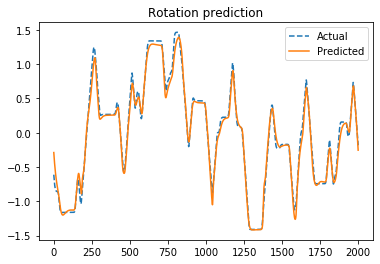

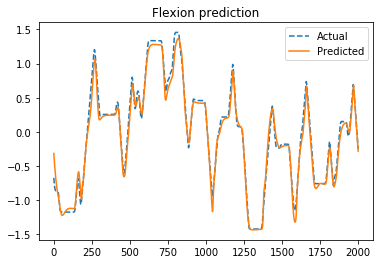

In [16]:
rot_positions, flex_positions = run_lstm(X_test_lstm, y_test_lstm)

plt.plot(y_test['rot_next_pos'], '--')
plt.plot(rot_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation prediction")
plt.show()

plt.plot(y_test['flex_next_pos'], '--')
plt.plot(flex_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Flexion prediction")
plt.show()

### Testing on a step input

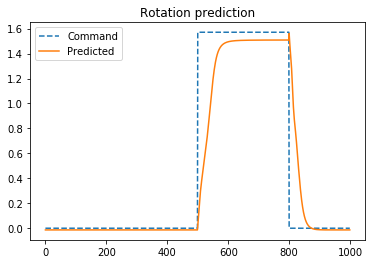

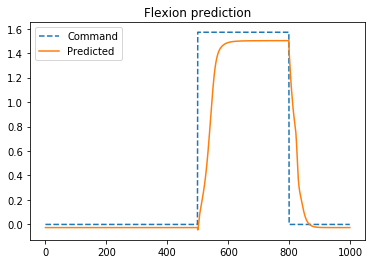

In [19]:
#Generalization to 90 is better
step = np.zeros((1000, 2))
step[500:800, 0] = math.pi/2
step[500:800, 1] = math.pi/2

rot_positions, flex_positions = run_lstm(step)

plt.plot(step[:, 0], '--')
plt.plot(rot_positions)
plt.legend(['Command', 'Predicted'])
plt.title("Rotation prediction")
plt.show()

plt.plot(step[:, 1], '--')
plt.plot(flex_positions)
plt.legend(['Command', 'Predicted'])
plt.title("Flexion prediction")
plt.show()

# Neural Network

In [116]:
nn = Sequential()
nn.add(Dense(8, input_shape=(6,), activation='relu'))
nn.add(Dense(4))

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)
nn.compile(opt, loss='mse')
nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 8)                 56        
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 36        
Total params: 92
Trainable params: 92
Non-trainable params: 0
_________________________________________________________________


In [117]:
nn.fit(X_train, y_train, epochs=100, verbose=1)

Epoch 1/100
8000/8000 [==============================] - 1s 137us/step - loss: 0.6438
Epoch 2/100
8000/8000 [==============================] - 0s 24us/step - loss: 0.1106
Epoch 3/100
8000/8000 [==============================] - 0s 24us/step - loss: 0.0607
Epoch 4/100
8000/8000 [==============================] - ETA: 0s - loss: 0.048 - 0s 24us/step - loss: 0.0467
Epoch 5/100
8000/8000 [==============================] - 0s 24us/step - loss: 0.0386
Epoch 6/100
8000/8000 [==============================] - 0s 24us/step - loss: 0.0330
Epoch 7/100
8000/8000 [==============================] - 0s 24us/step - loss: 0.0292
Epoch 8/100
8000/8000 [==============================] - 0s 25us/step - loss: 0.0270
Epoch 9/100
8000/8000 [==============================] - 0s 23us/step - loss: 0.0258
Epoch 10/100
8000/8000 [==============================] - 0s 25us/step - loss: 0.0251
Epoch 11/100
8000/8000 [==============================] - 0s 27us/step - loss: 0.0247
Epoch 12/100
8000/8000 [==============

### Testing on test set

MSE: 0.4877646341271577


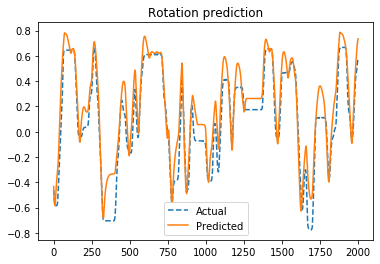

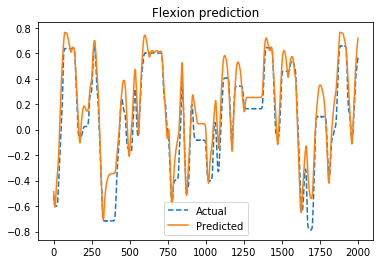

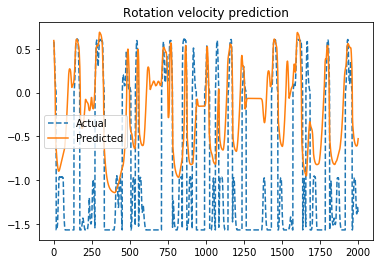

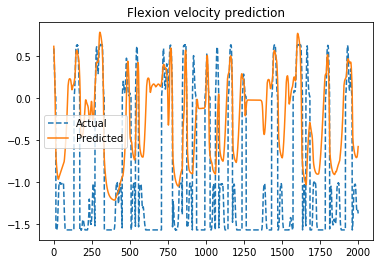

In [118]:
rot_positions = np.zeros(len(X_test))
flex_positions = np.zeros(len(X_test))
rot_velocities = np.zeros(len(X_test))
flex_velocities = np.zeros(len(X_test))

rot_cur_pos = X_test['rot_cur_pos'].iloc[0]
flex_cur_pos = X_test['flex_cur_pos'].iloc[0]
rot_cur_vel = X_test['rot_cur_vel'].iloc[0]
flex_cur_vel = X_test['flex_cur_vel'].iloc[0]
mse = 0
for i in range(len(X_test)):
    rot_positions[i] = rot_cur_pos
    flex_positions[i] = flex_cur_pos
    rot_velocities[i] = rot_cur_vel
    flex_velocities[i] = flex_cur_vel

    rot_command = X_test['rot_command'].iloc[i]
    flex_command = X_test['flex_command'].iloc[i]

    model_input = np.array([[rot_command, flex_command, rot_cur_pos, flex_cur_pos, rot_cur_vel, flex_cur_vel]])
    model_output = nn.predict(model_input, batch_size=1)[0]
    rot_cur_pos = model_output[0]
    flex_cur_pos = model_output[1]
    rot_cur_vel = model_output[2]
    flex_cur_vel = model_output[3]
    
    mse += mean_squared_error(y_test.iloc[i], model_output)
mse /= len(X_test)
print("MSE:",mse)

plt.plot(y_test['rot_next_pos'], '--')
plt.plot(rot_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation prediction")
plt.show()

plt.plot(y_test['flex_next_pos'], '--')
plt.plot(flex_positions)
plt.legend(['Actual', 'Predicted'])
plt.title("Flexion prediction")
plt.show()

plt.plot(y_test['rot_next_vel'], '--')
plt.plot(rot_velocities)
plt.legend(['Actual', 'Predicted'])
plt.title("Rotation velocity prediction")
plt.show()

plt.plot(y_test['flex_next_vel'], '--')
plt.plot(flex_velocities)
plt.legend(['Actual', 'Predicted'])
plt.title("Flexion velocity prediction")
plt.show()
